## Imports

In [143]:
import yaml
import os
from pathlib import Path
import pandas as pd
import struct
import random
import subprocess
import numpy as np
import matplotlib.pyplot as plt
import sys
import math
import re

# also: cd hammer && pip install -e . 

## Setup

In [144]:
# experiment setup
PDK = 'sky130'
CLOCK_PERIOD = 10 if PDK == 'sky130' else 2 # ns

# generate custom make str for each test
make_extra = f"pdk={PDK}"
if PDK == 'intech22': make_extra += f" PDK_CONF=experiments/intech22.yml"

# useful paths
energy_char_dpath = Path(os.getcwd()).parent
tests_dpath = energy_char_dpath/f'experiments/tests-{PDK}'
tests_dpath

PosixPath('/bwrcq/scratch/nayiri/hammer-sep24/e2e/hammer-energy-char/experiments/tests-sky130')

# Design Selection

In [196]:
# get pdk clock periods, paths
PDKs = [PDK]
test_paths = {}
for pdk in PDKs:
    test_paths[pdk] = energy_char_dpath/f'experiments/tests-{pdk}'

operations = ['add', 'mul', 'fp_mul', 'fp_add', 'bf_add', 'bf_mul']

# num_inputs, widths, activity_factors = 50, [8, 16, 32, 64], [0.1, 0.3, 0.7, 1.0]
num_inputs, widths, activity_factors = 50, [8,16,32], [0.1, 0.5, 1.0]
clock_periods = [CLOCK_PERIOD] # ns, clock periods to apply to all designs; eventually try sweeping this


## Global Vars

In [197]:
modules = {op:op for op in operations}
modules['bf_add'] = 'fp_add' ## bf_add uses the same module as fp_add
modules['bf_mul'] = 'fp_mul'

module_to_inst = {'add':'adder0', 'mul':'multiplier0', 'fp_add':'fp_add', 'fp_mul':'fp_mul'}
clock_name = {'add':'clock', 'mul':'clock', 'fp_add':'clk', 'fp_mul':'clk'} ## name of clock for respective module name

float_to_bin = {}
# Get the width of the mantissa given the entire width
def getMantissaWidth(width, operation):
    mantissa_widths = {(2**i):0 for i in range(3, 7)}
    if (operation in ['fp_add', 'fp_mul']):
        mantissa_widths = {8:3, 16:10, 32:23, 64:52}
    # Different widths for bfs
    elif (operation in ['bf_add', 'bf_mul']):
        mantissa_widths = {16:7}
    return mantissa_widths[width]

# Get the width of the exponent given the entire width
def getExponentWidth(width, operation):
    exponent_widths = {(2**i):0 for i in range(3, 7)}
    if (operation in ['fp_add', 'fp_mul']):
        exponent_widths = {8:4, 16:5, 32:8, 64:11}
    # Different widths for bfs
    elif (operation in ['bf_add', 'bf_mul']):
        exponent_widths = {16:8}
    return exponent_widths[width]

# Get the exponent bias given the exponent width
def getExponentBias(exponent_width):
    return (2 ** (exponent_width - 1)) - 1


design_minclock_dict = {}
# optional:
# design_minclock_dict={'add4': 4, 'add8': 4, 'add16': 4, 'add32': 4, 'add64': 4, 'mul4': 5, 'mul8': 5, 'mul16': 6, 'mul32': 6, 'mul64': 5}

'''
tests dict
  name format: <design>-<test_name>
      inputs: list, where each item is a tuple of items per line in input.txt
      defines: for verilog
'''

'\ntests dict\n  name format: <design>-<test_name>\n      inputs: list, where each item is a tuple of items per line in input.txt\n      defines: for verilog\n'

## Functions for Test Generation

In [198]:
    ## Integer -> Binary
    def getBinary(num, width):
        binary_str = ""
        for i in range(width):
            if (num & (1 << i)):
                binary_str += '1'
            else:
                binary_str += '0'
        return binary_str[::-1]

    ## Binary -> Integer
    def convertStrToInt(binary):
        ret = 0
        binary = binary[::-1]
        for i in range(len(binary)):
            if (binary[i] == '1'):
                ret += (2 ** i)
        return ret

    ## Binary -> FPU
    def convertStrToFPU(bin, operation):
        #print("Converting string to fpu", bin, operation)

        mantissa_len = getMantissaWidth(len(bin), operation)
        exponent_len = getExponentWidth(len(bin), operation)
        exp_bias = getExponentBias(exponent_len)
        exp_str = bin[1:1+exponent_len]
        mantissa_str = bin[1+exponent_len:1+exponent_len+mantissa_len]
        
        ## special cases; return None in these cases since we wan't to work with numbers

        ## 0 case
        if (bin == '0' * len(bin)):
            float_to_bin[(0, len(bin), operation)] = bin
            return None
        ## -inf case
        if (bin == '1' + '1' * exponent_len + '0' * mantissa_len):
            float_to_bin[(-float('inf'), len(bin), operation)] = bin
            return None
        ## inf case
        if (bin == '0' + '1' * exponent_len + '0' * mantissa_len):
            float_to_bin[(float('inf'), len(bin), operation)] = bin
            return None
        ## denormalized
        if (exp_str == '0' * exponent_len):
            float_to_bin[(float('nan'), len(bin), operation)] = bin
            return None
        ## nan
        if (exp_str == '1' * exponent_len):
            float_to_bin[(float('nan'), len(bin), operation)] = bin
            return None


        exponent_val = 2 ** (convertStrToInt(exp_str) - exp_bias)
        sign = (-1) ** (0 if bin[0] == '0' else 1)
        
        frac_val = 1.0
        for i in range(len(mantissa_str)):
            if (mantissa_str[i] == '1'):
                frac_val += 2 ** (-(i + 1))
        ret = sign * exponent_val * frac_val
        float_to_bin[(ret, len(bin), operation)] = bin
        return ret


    ## Flip binary string given activity factor (prob)
    def flip_str(cur_str, width, prob):
        ret = ''
        for i in range(width):
            on = (cur_str[i] == '1')
            rand_num = random.random()
            ## flip bit
            if (rand_num <= prob):
                ret += ('1' if not on else '0')
            else:
                ret += ('1' if on else '0')
        return ret

    ## Flip number given activity factor (prob)
    def flip_num(cur_num, width, prob):
        ret = 0
        for i in range(width):
            on = ((cur_num & (1 << i)) > 0)
            rand_num = random.random()
            ## flip bit
            if (rand_num <= prob):
                ret += ((not on) * (1 << i))
            else:
                ret += (on * (1 << i))
        return ret

    ## find (a, b) s.t. a + b = num or a * b = num
    def findNums(num, operation, ind):
        a, b = 0, 0
        if (operation == 'add'):
            a = random.randint(0, num)
            b = num - a
        elif (operation == 'mul'):
            if (ind % 2 == 0):
                a, b = 1, num
            else:
                a, b = num, 1
        elif (operation in ['fp_add', 'bf_add']):
            if (ind % 2 == 0):
                a, b = 0, num
            else:
                a, b = num, 0
        elif (operation in ['fp_mul', 'bf_mul']):
            if (ind % 2 == 0):
                a, b = 1, num
            else:
                a, b = num, 1
        return (a, b)

    # Generate a random binary string
    def genRandBin(width):
        ret = ""
        for i in range(width):
            num = random.randint(1, 100)
            if (num <= 50):
                ret += '0'
            else:
                ret += '1'
        return ret

    def getInputs(width, activity_factor, num_iter, operation, rand=False):
        nums = []
        lastBinStr = genRandBin(width) 
        if (operation in ['fp_add', 'bf_add', 'fp_mul', 'bf_mul']):
            while (convertStrToFPU(lastBinStr, operation) == None):
                lastBinStr = genRandBin(width)

        for i in range(num_iter):
            if (operation == 'add' or operation == 'mul'):
                if (not rand):
                    lastBinStr = flip_str(lastBinStr, width, activity_factor)
                    new_num = convertStrToInt(lastBinStr)
                    nums.append(findNums(new_num, operation, i))
                else:
                    nums.append((convertStrToInt(genRandBin(width)), convertStrToInt(genRandBin(width))))
            elif (operation in ['fp_add', 'bf_add', 'fp_mul', 'bf_mul']):
                if (not rand):
                    new_str = flip_str(lastBinStr, width, activity_factor)
                    fpu_val = convertStrToFPU(new_str, operation)
                    while (fpu_val == None):
                        new_str = flip_str(lastBinStr, width, activity_factor)
                        fpu_val = convertStrToFPU(new_str, operation)
                    nums.append(findNums(fpu_val, operation, i))
                    lastBinStr = new_str
                else:
                    fpu_val1 = convertStrToFPU(genRandBin(width), operation)
                    while (fpu_val1 == None):
                        fpu_val1 = convertStrToFPU(genRandBin(width), operation)
                    fpu_val2 = convertStrToFPU(genRandBin(width), operation)
                    while (fpu_val2 == None):
                        fpu_val2 = convertStrToFPU(genRandBin(width), operation)
                    nums.append((fpu_val1, fpu_val2))
        return nums

## YAML Config

In [199]:
def writeYaml(td):
    defines_str = '\n'.join( [ f"  - {key}={val}" for key,val in td['defines'].items() ] )
    clock_period = td["clock_period"]
    delays = [f"""{{name: {i}, clock: {td['clock']}, delay: "1", direction: input}}""" for i in td['input_ports']]
    delays += [f"""{{name: {i}, clock: {td['clock']}, delay: "1", direction: output}}""" for i in td['output_ports']]
    delays = ',\n  '.join(delays)
    cfg = f"""\
vlsi.core.build_system: make
vlsi.inputs.power_spec_type: cpf
vlsi.inputs.power_spec_mode: auto

design.defines: &DEFINES
  - CLOCK_PERIOD={clock_period}
{defines_str}

vlsi.inputs.clocks: [{{name: {td['clock']}, period: "{clock_period}ns", uncertainty: "100ps"}}]

vlsi.inputs.delays: [
  {delays}
]

synthesis.inputs:
  top_module: {td['top_module']}
  input_files: {td['vsrcs']}
  defines: *DEFINES

sim.inputs:
  top_module: {td['top_module']}
  tb_name: {td['tb_name']}
  tb_dut: {td['tb_dut']}
  options: ["-timescale=1ns/10ps", "-sverilog"]
  options_meta: append
  defines: *DEFINES
  defines_meta: append
  level: rtl
  input_files: {td['vsrcs'] + td['vsrcs_tb']}

vlsi.core.power_tool: hammer.power.joules
power.inputs:
  level: rtl
  top_module: {td['top_module']}
  tb_name: {td['tb_name']}
  tb_dut: {td['tb_dut']}
  defines: *DEFINES
  input_files: {td['vsrcs']}
  report_configs:
    - waveform_path: {td['root']}/output.fsdb
      report_stem: {td['root']}/power
      toggle_signal: {td['clock']}
      num_toggles: 1
      levels: all
      output_formats:
      - report
      - plot_profile
      - ppa
"""
    with (td['root']/'config.yml').open('w') as f:
        f.write(cfg)

## Functions for Creating Tests

In [200]:
def decimalFormat(factor):
    sf = str(factor).replace('.','p')
    return sf

formatted_op = dict(add='add_int',mul='mul_int',fp_add='add_fp',bf_add='add_bf',fp_mul='mul_fp',bf_mul='mul_bf')
# def formattedOp(op):
#     if (op == 'add'):
#         return 'add_int'
#     if (op == 'mul'):
#         return 'mul_int'
#     if (op == 'fp_add'):
#         return 'add_fp'
#     if (op == 'bf_add'):
#         return 'add_bf'
#     if (op == 'fp_mul'):
#         return 'mul_fp'
#     if (op == 'bf_mul'):
#         return 'mul_bf'


def createTest(operation, width, factor, clock_period, rand=False):
    design = f"{formatted_op[operation]}{width}-{clock_period}ns"
    test_name = f'{design}-oaf_{decimalFormat(factor)}'
    if (rand):
        test_name = f'{design}-rand'

    ## set inputs
    new_test = {'inputs': getInputs(width, factor, num_inputs, operation, rand), 'defines': dict(WIDTH=width)}

    new_test['operation'] = operation
    new_test['width'] = width
    new_test['mantissa'] = getMantissaWidth(width, operation)
    new_test['exponent'] = getExponentWidth(width, operation)
    new_test['output_af'] = factor

    ## verilog info
    module = modules[operation]
    new_test['design'] = design
    new_test['inst'] = f'/{module_to_inst[module]}' if module in {'fp_add','fp_mul'} else f'/{module}/{module_to_inst[module]}'
    new_test['clock'] = clock_name[module]
    new_test['vsrcs'] = [f'src/{module}.v']
    new_test['vsrcs_tb'] = [f'src/{module}_tb.v']
    new_test['top_module'] = f'{module}'
    new_test['tb_name'] = f'{module}_tb'
    new_test['tb_dut'] = f'{module}_dut'
    new_test['input_ports'] = ['in0','in1']
    new_test['output_ports'] = ['out']
    new_test['clock_period'] = clock_period
    new_test['input_format'] = 'float' + str(width)

    ## root dir
    root = tests_dpath/test_name
    root.mkdir(exist_ok=True,parents=True)
    new_test['defines']['TESTROOT'] = root
    if (operation in ['fp_add', 'bf_add', 'fp_mul', 'bf_mul']):
        new_test['defines']['MANTISSA'] = new_test['mantissa']
        new_test['defines']['EXPONENT'] = new_test['exponent']
    new_test['root'] = root

    ## design dir
    new_test['obj_dpath'] = energy_char_dpath/f"build-{PDK}-cm/{design}"

    cfg = str(new_test['root']/'config.yml')
    new_test['make'] = f"design={new_test['design']} {make_extra} DESIGN_CONF={cfg}"

    return test_name, new_test

# convert data operands to binary format to dump to input.txt (gets more complicated for floats)
def val2binary(val,width, operation) -> str:
    if (operation[:2] in {'fp', 'bf'}):
        return float_to_bin[(val, width, operation)]
    if type(val) == str: return val
    elif type(val) == int: return '{0:b}'.format(val)
    else: assert(False), f"Invalid dtype, {type(val)}"

## write inputs to test file
def writeInput(test_info):
    with (test_info['root']/'input.txt').open('w') as f:
        for operands in test_info['inputs']:
            f.write(" ".join([val2binary(operand,test_info['width'], test_info['operation']) for operand in operands]) + '\n')

## Generate All Tests

In [201]:
## convert 1 to ieee 754
for op in ['fp_add', 'fp_add', 'fp_mul', 'bf_add', 'bf_mul']:
    for w in widths:
        if ((op[:2] == 'bf') and (w != 16)):
            continue
        exp_width = getExponentWidth(w, op)
        exp_bias = getExponentBias(exp_width)
        bin = '0' + getBinary(exp_bias, exp_width) + '0' * (w - 1 - exp_width)
        float_to_bin[(1, w, op)] = bin
        float_to_bin[(0, w, op)] = '0' * w
        float_to_bin[(float('inf'), w, op)] = '0' + '1' * (w - 1)
        float_to_bin[(-float('inf'), w, op)] = '1' * w

        

tests_dict = {}
for operation in operations:
    for width in widths:
        for b in [False, True]:
            if (('bf' in operation) and (width != 16)):
                continue
            design = operation+str(width)
            design_clock_periods = clock_periods.copy()
            if design in design_minclock_dict:
                design_clock_periods.append(design_minclock_dict[design])
            for clock_period in design_clock_periods:
                if (b):
                        print("Working on", operation, width, b, clock_period, None)
                        test_name, test_info = createTest(operation, width, None, clock_period, b)
                        writeInput(test_info)
                        writeYaml(test_info)
                        tests_dict[test_name] = test_info
                        print(test_info)
                else: 
                    for factor in activity_factors:
                        print("Working on", operation, width, b, clock_period, factor)
                        test_name, test_info = createTest(operation, width, factor, clock_period, b)
                        writeInput(test_info)
                        writeYaml(test_info)
                        tests_dict[test_name] = test_info
                        print(test_info)

Working on add 8 False 10 0.1
{'inputs': [(27, 34), (0, 61), (3, 58), (158, 31), (73, 116), (52, 137), (82, 107), (58, 99), (130, 27), (110, 49), (70, 69), (4, 135), (16, 3), (2, 29), (4, 19), (25, 190), (89, 126), (119, 32), (57, 94), (16, 7), (23, 128), (6, 0), (171, 27), (17, 181), (196, 2), (65, 133), (59, 71), (8, 122), (76, 54), (44, 86), (68, 70), (9, 1), (6, 4), (6, 4), (8, 2), (0, 8), (1, 23), (12, 12), (3, 6), (17, 8), (45, 4), (3, 46), (4, 45), (44, 5), (140, 101), (185, 24), (15, 194), (73, 144), (131, 86), (116, 101)], 'defines': {'WIDTH': 8, 'TESTROOT': PosixPath('/bwrcq/scratch/nayiri/hammer-sep24/e2e/hammer-energy-char/experiments/tests-sky130/add_int8-10ns-oaf_0p1')}, 'operation': 'add', 'width': 8, 'mantissa': 0, 'exponent': 0, 'output_af': 0.1, 'design': 'add_int8-10ns', 'inst': '/add/adder0', 'clock': 'clock', 'vsrcs': ['src/add.v'], 'vsrcs_tb': ['src/add_tb.v'], 'top_module': 'add', 'tb_name': 'add_tb', 'tb_dut': 'add_dut', 'input_ports': ['in0', 'in1'], 'output_po

## Run Experiments

In [202]:
# Setup
def runMakeCmd(make_target,td,fp,overwrite=False,verbose=False):
    if overwrite or not fp.exists():
        cmd = f"make {make_target} {td['make']}"
        print(f'Executing commmand: {cmd}')
        subprocess.run(cmd, cwd=energy_char_dpath,
                        shell=True, check=True, capture_output=(not verbose))

# subprocess.run starts in an empty environment, need to ensure it can find hammer-vlsi
python_exec_fpath = Path(sys.executable)
env_dpath = str(python_exec_fpath.parent)
if not os.environ['PATH'].startswith(env_dpath): os.environ['PATH'] = env_dpath + ':' + os.environ['PATH']

def runBuild(td,overwrite=False,verbose=False):
    runMakeCmd("build -B",td,
                td['obj_dpath'],
                overwrite,verbose)

def runSim(td,overwrite=False,verbose=False):
    runMakeCmd("redo-sim-rtl",td,
                td['root']/'output.fsdb',
                overwrite,verbose)

def runPowerSyn(td,overwrite=False,verbose=False):
    runMakeCmd("power-rtl",td,
                td['obj_dpath']/'power-rtl-rundir/pre_report_power',
                overwrite,verbose)

def runPowerReport(td,overwrite=False,verbose=False):
    runMakeCmd("redo-power-rtl args='--only_step report_power'",td,
                td['root']/'power.power.rpt',
                overwrite,verbose)


In [203]:
# build
overwrite = False
build_dpaths = {td['obj_dpath']: t for t,td in tests_dict.items()} # run build once per build dir (not once per test)
for bd,t in build_dpaths.items():
    runBuild(tests_dict[t],overwrite)

In [204]:
# power-rtl: synthesize design in power tool + save checkpoint
kw = dict(overwrite=False,verbose=True)
for bd,t in build_dpaths.items():
    runSim(tests_dict[t],**kw)
    runPowerSyn(tests_dict[t],**kw)
    runPowerReport(tests_dict[t],**kw)

## Adjust Clock Periods to Fix Timing

In [205]:
# # TODO: check ppa.rpt & adjust clock period, print updated values
# #       in a dict that user copies to the top? it's a bit messy but we prolly don't want to auto-loop

# def parseSlack(fname):
#     slacks = []
#     with open(fname, 'r') as f:
#         lines = f.readlines()
#         for line in lines:
#             line = line.split()
#             if (line[0] == 'register'):
#                 slacks.append(float(line[6]))
#     return min(slacks)

# overwrite = False
# new_clocks = {}
# for bd,t in build_dpaths.items():
#     cur_test = tests_dict[t]
#     clock_period = cur_test['clock_period']
#     slack = parseSlack(cur_test['root']/'power.ppa.rpt')
#     if 0 <= slack and slack < 500: slack = 0 # don't change clock period
#     new_clock_period = math.floor((clock_period * 1000 - slack) / 1000)
#     new_clocks[t.split('-')[0]] = new_clock_period

# print(f"design_minclock_dict={new_clocks}")
# # copy output to top if desired

In [206]:
# sim-rtl
for t,td in tests_dict.items():
    runSim(td, overwrite=False, verbose=True)
    runPowerReport(td, overwrite=False, verbose=True)

In [207]:
def parse_hier_power_rpt(td) -> list:
    fpath = td['root']/'power.hier.power.rpt'
    print(fpath)
    with fpath.open('r') as f: lines = f.readlines()
    for l in lines:
        words = l.split()
        if l.startswith('Power Unit'):
            assert(words[-1] == 'mW'), f"Wrong power unit in report, {l}"
        if td['inst'] == words[-1]:
            #print([float(p) for p in words[2:6]])
            return [float(p) for p in words[2:6]]
    return []

def parse_power_profile(td) -> float:
    fpath = td['root']/'power.profile.png.data'
    with fpath.open('r') as f: lines = f.readlines()
    header = lines[0]
    assert((f"-ykeylabel {td['inst']}:total:total" in header) or (f"-ykeylabel {td['inst'][1:]}:total:total" in header)) # make sure we got the correct power trace
    match = re.search(r'simulation time \((\w+)\)', header)
    unit = match.group(1) if match else None
    if unit == 'ns': scaling = 1
    elif unit == 'ps': scaling = 1e-3
    elif unit == 'fs': scaling = 1e-6
    else: raise ValueError(f"Unit {unit} not supported in file {fpath}")
    time_power = [l.split() for l in lines]
    time_power = [tp for tp in time_power if len(tp) == 2]
    times = [float(t)*scaling for t,p in time_power]
    powers = [float(p) for t,p in time_power][1:-1] # skip first/last values bc they're misleading
    avgpow = sum(powers)/len(powers)
    return times[-1]-times[0], avgpow # end-start


power = []

for t,td in tests_dict.items():
    power.append(parse_hier_power_rpt(td))

power = pd.DataFrame(power,   #  mW
                     columns=['Leakage','Internal','Switching','Total'],
                     index=tests_dict.keys()) # type: ignore


time_ns = [parse_power_profile(td)[0] for td in tests_dict.values()]
energy = power.mul(time_ns,axis=0) / num_inputs # mW * ns = pJ
energy.columns = [c+' Energy (pJ)' for c in energy.columns]
database = pd.concat([energy,power],axis=1)

database.insert(0,'output_af',[td['output_af'] for td in tests_dict.values()])
database.insert(0,'time_ns',time_ns)
database.insert(0,'test',[i.split('-')[1] for i in database.index])
database.insert(0,'design',[i.split('-')[0] for i in database.index])

#print(results_for_plots)
database.to_hdf(PDK+'.h5',key='df',mode='w')
database


/bwrcq/scratch/nayiri/hammer-sep24/e2e/hammer-energy-char/experiments/tests-sky130/add_int8-10ns-oaf_0p1/power.hier.power.rpt
/bwrcq/scratch/nayiri/hammer-sep24/e2e/hammer-energy-char/experiments/tests-sky130/add_int8-10ns-oaf_0p5/power.hier.power.rpt
/bwrcq/scratch/nayiri/hammer-sep24/e2e/hammer-energy-char/experiments/tests-sky130/add_int8-10ns-oaf_1p0/power.hier.power.rpt
/bwrcq/scratch/nayiri/hammer-sep24/e2e/hammer-energy-char/experiments/tests-sky130/add_int8-10ns-rand/power.hier.power.rpt
/bwrcq/scratch/nayiri/hammer-sep24/e2e/hammer-energy-char/experiments/tests-sky130/add_int16-10ns-oaf_0p1/power.hier.power.rpt
/bwrcq/scratch/nayiri/hammer-sep24/e2e/hammer-energy-char/experiments/tests-sky130/add_int16-10ns-oaf_0p5/power.hier.power.rpt
/bwrcq/scratch/nayiri/hammer-sep24/e2e/hammer-energy-char/experiments/tests-sky130/add_int16-10ns-oaf_1p0/power.hier.power.rpt
/bwrcq/scratch/nayiri/hammer-sep24/e2e/hammer-energy-char/experiments/tests-sky130/add_int16-10ns-rand/power.hier.powe

,design,test,time_ns,output_af,Leakage Energy (pJ),Internal Energy (pJ),Switching Energy (pJ),Total Energy (pJ),Leakage,Internal,Switching,Total
add_int8-10ns-oaf_0p1,add_int8,10ns,505.0,0.1,0.000002,0.215165,1.391063,1.606223,1.490070e-07,0.021303,0.137729,0.159032
add_int8-10ns-oaf_0p5,add_int8,10ns,505.0,0.5,0.000002,0.383731,6.249082,6.632811,1.497010e-07,0.037993,0.618721,0.656714
add_int8-10ns-oaf_1p0,add_int8,10ns,505.0,1.0,0.000001,0.569980,12.952038,13.522082,1.475830e-07,0.056434,1.282380,1.338820
add_int8-10ns-rand,add_int8,10ns,505.0,NaN,0.000002,0.400209,6.511581,6.911794,1.503490e-07,0.039625,0.644711,0.684336
add_int16-10ns-oaf_0p1,add_int16,10ns,505.0,0.1,0.000003,0.446592,3.153028,3.599620,3.217030e-07,0.044217,0.312181,0.356398
add_int16-10ns-oaf_0p5,add_int16,10ns,505.0,0.5,0.000003,0.815986,13.535414,14.351494,3.230790e-07,0.080791,1.340140,1.420940
add_int16-10ns-oaf_1p0,add_int16,10ns,505.0,1.0,0.000003,1.244169,26.001339,27.245457,3.230330e-07,0.123185,2.574390,2.697570
add_int16-10ns-rand,add_int16,10ns,505.0,NaN,0.000003,0.824415,13.725294,14.549757,3.272950e-07,0.081625,1.358940,1.440570
add_int32-10ns-oaf_0p1,add_int32,10ns,505.0,0.1,0.000008,1.046724,6.739296,7.786029,7.649410e-07,0.103636,0.667257,0.770894
add_int32-10ns-oaf_0p5,add_int32,10ns,505.0,0.5,0.000008,1.721151,27.351507,29.072648,7.651220e-07,0.170411,2.708070,2.878480


## Generate Energy vs. Activity Factor Plot

['add_int8', 'add_int16', 'add_int32', 'mul_int8', 'mul_int16', 'mul_int32', 'mul_fp8', 'mul_fp16', 'mul_fp32', 'add_fp8', 'add_fp16', 'add_fp32', 'add_bf16', 'mul_bf16']


''

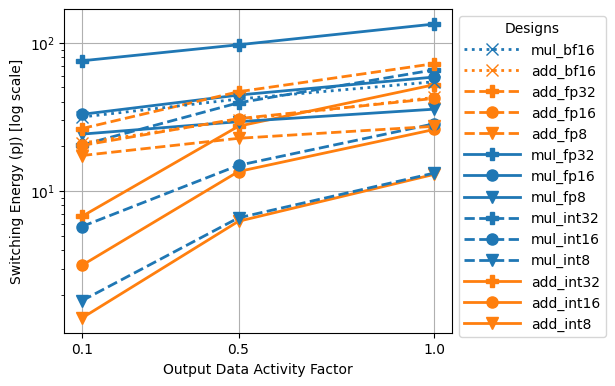

In [212]:
ykey = 'Switching Energy (pJ)'
# ykey = 'Internal (pJ)'

plt.figure(figsize=(5,4.2))

width_markers = {8: 'v', 16: 'o', 32:'P', 64: '^'}
operation_colors = dict(add='tab:orange',mul='tab:blue',fp_add='tab:orange', fp_mul='tab:blue', bf_mul='tab:blue', bf_add='tab:orange')
operation_linestyles = dict(add='-',mul='--',fp_add='--',fp_mul="-", bf_add=':', bf_mul=':')


designs =  list(dict.fromkeys(database['design']).keys())
print(designs)
for design in designs:
    bf = '_bf' in design
    df = database[~database['output_af'].isna() & (database['design'] == design)].sort_values('output_af')
    hd = df['output_af']
    t = df.index[0]
    width = tests_dict[t]['width']
    op = tests_dict[t]['operation']
    e = df[ykey]
    if ('-rand' in e):
        continue
    plt.plot(hd,e,label=design,
            color=operation_colors[op],
            linewidth=2,
            linestyle=operation_linestyles[op],
            markersize=8,
            marker=width_markers[width] if not bf else 'x')
    plt.xticks(hd)

handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles[::-1],labels[::-1],bbox_to_anchor=(1,1),title='Designs',handlelength=4)
plt.xlabel('Output Data Activity Factor')
plt.ylabel(ykey + ' [log scale]')
plt.grid(axis='both')
# plt.ylim(bottom=0)
plt.yscale('log')
;

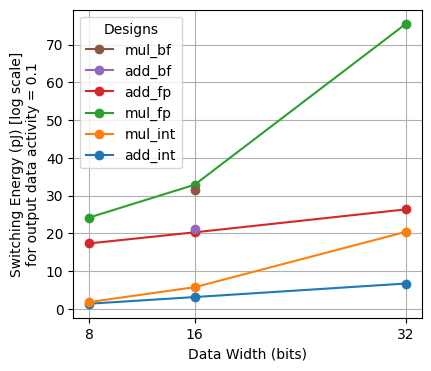

In [209]:
ykey = "Switching Energy (pJ)"

output_af = 0.1

plt.figure(figsize=(4.5,4))

data = database[database['output_af'] == output_af]
formatted_ops = [formatted_op[op] for op in operations]
xt = []
for operation in formatted_ops:
    widths, skip = [], []
    ind = 0
    for val in data['design']:
        if operation == val[:len(operation)]:
            widths.append(int(val.replace(operation,'')))
        else:
            skip.append(ind)
        ind += 1
    energies = data[ykey].values
    valid_energies = []
    for i in range(len(energies)):
        if i not in skip:
            valid_energies.append(energies[i])
    # print(widths, valid_energies)
    plt.plot(widths,valid_energies,'o-', label=operation)
    if len(widths) > len(xt): xt = widths

plt.xticks(xt)
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles[::-1],labels[::-1],title='Designs')

plt.xlabel("Data Width (bits)")
plt.ylabel(ykey + f' [log scale]\nfor output data activity = {output_af}')
plt.grid(axis='both')
# plt.ylim(3,500)
# plt.yscale('log')